# Nexflix Rating Recommendation  Analysis

Name: Chia Wei Tu

Student ID: 300289967

### Reference
The Dataset is form Data World https://data.world/chasewillden/netflix-shows




using KElbow Visualizer https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
implements the “elbow” method to help data scientists select the optimal number of clusters by fitting the model with a range of values for 𝐾. 

Using Gaussian process classification (GPC) which is based on Laplace approximation and it is used for approximating the non-Gaussian posterior by a Gaussian.
The implementation is based on Algorithm 3.1, 3.2, and 5.1 of Gaussian Processes for Machine Learning (GPML) by Rasmussen and Williams.https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html


Using SGDClassifier() which is a Linear classifiers (SVM, logistic regression, etc.) with SGD training. This implementation works with data represented as dense or sparse arrays of floating point values for the features. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM).
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

## Problem

Netflix canceled user film review system and use artificial intelligence algorithms to recommend movies in these years. Does the percentage really indicates how well Netflix system feel the recommended content fits the specific user? Does the recommendation score really help user find their love shows and movies?

The dataset is about each title (movie name)'s rating information, including the rating category for different ages, the description, the release year and the rating score. I'll use classification and regression model to test the each features. Analyze the features's impact about the user rating and test the model whether have good recommendation for user.

## Load the Library

In [1]:
#!pip install yellowbrick
#import yellowbrick library for elbow visualizer
from yellowbrick.cluster import KElbowVisualizer

In [2]:
#import the python library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import the classification library
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report , confusion_matrix  
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
%matplotlib inline 

## Read the Data

In [3]:
# Read the data
df=pd.read_csv('netflix.csv') 

df.head()

,title,rating,ratingLevel,ratingDescription,release year,user rating score,user rating size
0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",80,2004,82.0,80
1,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,NaN,82
2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80
3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80
4,How I Met Your Mother,TV-PG,Parental guidance suggested. May not be suitab...,70,2014,94.0,80


## Data Wrangling 

In [4]:
#check the null values
df.isnull().sum()

title                  0
rating                 0
ratingLevel           59
ratingDescription      0
release year           0
user rating score    395
user rating size       0
dtype: int64

In [5]:
#change some label name into underscore 
df.rename(columns={'release year': 'release_year'}, inplace=True)
df.rename(columns={'user rating score': 'user_rating_score'}, inplace=True)
df.rename(columns={'user rating size': 'user_rating_size'}, inplace=True)

In [6]:
#compute length of rating level 
df["ratingLevel_len"] = df['ratingLevel'].astype(str).apply(lambda x: len(x))

#fill the null values in user rating score to 0
df.user_rating_score.fillna(0, inplace=True)

#drop the ratingLevel column 
df=df.drop('ratingLevel', axis=1)

#display updated dataframe
df.head()

,title,rating,ratingDescription,release_year,user_rating_score,user_rating_size,ratingLevel_len
0,White Chicks,PG-13,80,2004,82.0,80,54
1,Lucky Number Slevin,R,100,2006,0.0,82,50
2,Grey's Anatomy,TV-14,90,2016,98.0,80,77
3,Prison Break,TV-14,90,2008,98.0,80,77
4,How I Met Your Mother,TV-PG,70,2014,94.0,80,66


In [7]:
#Examine the categorical columns in the netflix rating
df['rating'].value_counts()

TV-14       234
PG          170
TV-MA       148
G           138
TV-Y         68
TV-PG        59
TV-G         52
TV-Y7-FV     44
TV-Y7        38
R            19
PG-13        15
NR           14
UR            1
Name: rating, dtype: int64

In [8]:
rating = df['rating'] #get rating from dataframe
rating_list=[] #list variable for rating

#append "each raing name 
for r in rating:
    if r in ('G','TV-G', 'TV-Y'):    #all ages
        rating_list.append("Preschool")
    elif r in ('PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG'):  #over 7
        rating_list.append("Child")
    elif r in ('PG-13'):
        rating_list.append("Juvenile") #over 13
    elif r in ('TV-14'):
        rating_list.append("Teenager")  #over 16
    elif r in ('TV-MA' ,'R' ,'NR' ,'UR'):
        rating_list.append("Adult")   #over 18

#append new rating variable to the dataframe       
df['rating'] = rating_list

In [9]:
#Examine the categorical columns in the netflix user_rating_score
df['user_rating_score'].value_counts()

0.0     395
98.0     46
97.0     36
95.0     33
91.0     33
94.0     32
96.0     31
92.0     28
81.0     27
93.0     24
80.0     21
83.0     18
74.0     16
88.0     15
61.0     15
86.0     14
84.0     13
90.0     13
89.0     12
57.0     12
79.0     12
82.0     12
68.0     12
70.0     11
67.0     10
85.0     10
64.0     10
77.0     10
62.0      9
72.0      8
99.0      8
73.0      7
71.0      7
58.0      6
56.0      6
69.0      5
66.0      5
65.0      5
63.0      4
78.0      4
55.0      2
75.0      2
59.0      1
Name: user_rating_score, dtype: int64

In [10]:
#if user_rating_score >=80, highly recommend=yes, otherwise=No
#list variable
Highly_recommend = []

score = df["user_rating_score"]
for s in score:
    if s >=80:
        Highly_recommend.append("Yes")
    else:
        Highly_recommend.append("No")
               
#append to dataframe
df['Highly_recommend'] = Highly_recommend
df.head()

,title,rating,ratingDescription,release_year,user_rating_score,user_rating_size,ratingLevel_len,Highly_recommend
0,White Chicks,Juvenile,80,2004,82.0,80,54,Yes
1,Lucky Number Slevin,Adult,100,2006,0.0,82,50,No
2,Grey's Anatomy,Teenager,90,2016,98.0,80,77,Yes
3,Prison Break,Teenager,90,2008,98.0,80,77,Yes
4,How I Met Your Mother,Child,70,2014,94.0,80,66,Yes


In [11]:
#remove unrated score in user rating score
df = df[df.user_rating_score !=0]

In [12]:
#Examine the categorical columns in the netflix user_rating_size
df['user_rating_size'].value_counts()

80    605
Name: user_rating_size, dtype: int64

In [13]:
#see the crosstab between rating level and highy recommend
pd.crosstab(df['rating'],df['Highly_recommend'])

Highly_recommend,No,Yes
rating,,
Adult,17,92
Child,51,140
Juvenile,6,5
Preschool,56,50
Teenager,49,139


It seems more child and teenager Netflix shows will have highly score than other rating level's show

In [14]:
#see the crosstab between rating descrption and recommend 
pd.crosstab(df['ratingDescription'],df['Highly_recommend'])

Highly_recommend,No,Yes
ratingDescription,,
10,14,11
35,42,39
41,11,3
42,10,6
60,22,97
70,8,34
80,6,5
90,49,139
100,4,5


It shows that when the rating description is 90 ,there will have better result than other raing description(like more appealing than others)

## EDA

In [15]:
df.dtypes

title                 object
rating                object
ratingDescription      int64
release_year           int64
user_rating_score    float64
user_rating_size       int64
ratingLevel_len        int64
Highly_recommend      object
dtype: object

In [16]:
# Print out the summary statistics of the dataset
df.describe()

,ratingDescription,release_year,user_rating_score,user_rating_size,ratingLevel_len
count,605.000000,605.000000,605.000000,605.0,605.000000
mean,73.003306,2010.325620,84.094215,80.0,54.188430
std,27.884874,9.372431,12.344371,0.0,23.436066
min,10.000000,1940.000000,55.000000,80.0,3.000000
25%,60.000000,2007.000000,75.000000,80.0,38.000000
50%,80.000000,2015.000000,88.000000,80.0,66.000000
75%,90.000000,2016.000000,95.000000,80.0,77.000000
max,124.000000,2017.000000,99.000000,80.0,80.000000


### Univariate Analysis

Text(0.5, 1.0, 'rating')

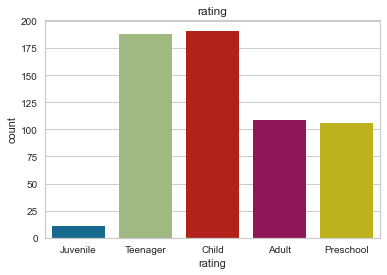

In [17]:
#Rating bar chart in differnt rating level
sns.countplot(x='rating', data=df)
plt.title('rating')

We can see child has most movies or tv shows on Netflix

Text(0.5, 1.0, 'Highly_recommend')

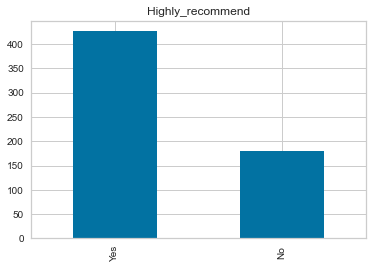

In [18]:
#Highly recommend bar chart (over 80 is yes)
df['Highly_recommend'].value_counts().plot(kind='bar') 
plt.title('Highly_recommend')

Most of subscribers will give over 80 scores to the Netflix shows or movies 

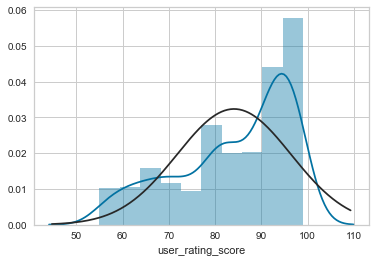

In [19]:
#normal distrbution of user rating score
from scipy.stats import norm
sns.distplot(df.user_rating_score, fit=norm)

the score between 90~100 is the most

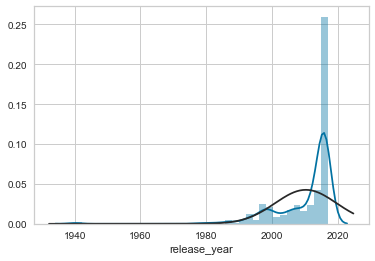

In [20]:
#normal distrbution of release year
from scipy.stats import norm
sns.distplot(df.release_year , fit=norm)

In [21]:
# remove some outliers 
df=df.drop(df.loc[df['release_year']<1980].index)

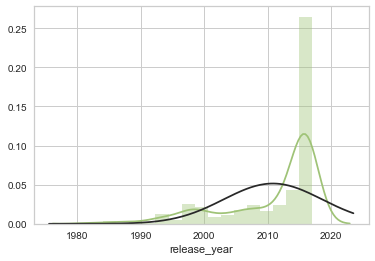

In [22]:
from scipy.stats import norm
sns.distplot(df.release_year,color='g' , fit=norm)
plt.savefig('release_year.png')

There have more release latest shows or movies from 2010 to 2020 on Netflix

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text major ticklabel objects>)

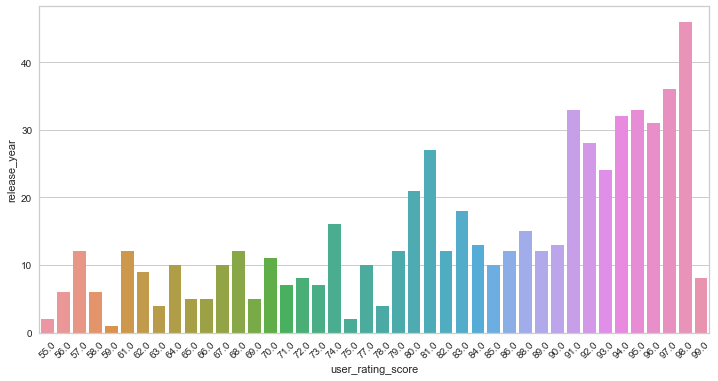

In [23]:
#The rating score group by release year
user_rating_score=df.groupby("user_rating_score")['release_year'].count().reset_index().sort_values(by='user_rating_score',ascending=False).reset_index(drop=True)
plt.figure(figsize=(12,6))
sns.barplot(x='user_rating_score',y='release_year', data=user_rating_score)
plt.xticks(rotation=45)

Ranges of scores from 91-98 seem to be more frequent

### Multivariate Analysis

Text(0.5, 1.0, 'User rating score vs Rating Description')

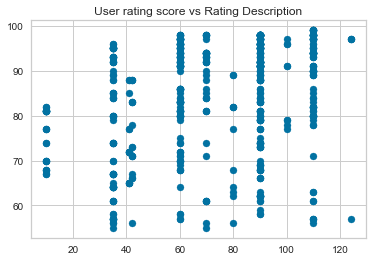

In [24]:
# relationship between User rating score vs Rating Description
plt.scatter(df.ratingDescription, df.user_rating_score)
plt.title('User rating score vs Rating Description')

The plot above seems dont have that much relationship between User rating score and Rating Description

Text(0.5, 1.0, 'User rating score vs Release year')

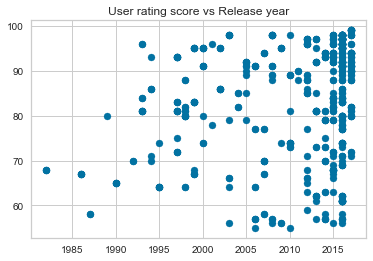

In [25]:
# relationship between User rating score vs Release year
plt.scatter(df.release_year, df.user_rating_score)
plt.title('User rating score vs Release year')

There no obviously relationship between User rating score and Release year. But still can see the latest year have higher score

Text(0.5, 1.0, 'User rating score vs Rating Level')

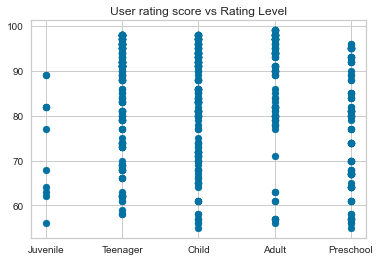

In [26]:
# relationship between User rating score vs Rating level
plt.scatter(df.rating,df.user_rating_score)
plt.title('User rating score vs Rating Level')

There no relationship between User rating score and Rating level

#### Drop Unneed Columns

In [27]:
#specify columns to drop and drop them
to_drop = ['title','user_rating_score','user_rating_size']

#drop the specified columns and assign the result to a new dataframe
df2 = df.drop(to_drop, axis=1)
df2.head()

,rating,ratingDescription,release_year,ratingLevel_len,Highly_recommend
0,Juvenile,80,2004,54,Yes
2,Teenager,90,2016,77,Yes
3,Teenager,90,2008,77,Yes
4,Child,70,2014,66,Yes
5,Teenager,90,2016,77,Yes


## Transformation

In [28]:
#convert rating and recommend into numerical dummy variables
df3 = pd.get_dummies(df2, drop_first=True)
df3

,ratingDescription,release_year,ratingLevel_len,rating_Child,rating_Juvenile,rating_Preschool,rating_Teenager,Highly_recommend_Yes
0,80,2004,54,0,1,0,0,1
2,90,2016,77,0,0,0,1,1
3,90,2008,77,0,0,0,1,1
4,70,2014,66,1,0,0,0,1
5,90,2016,77,0,0,0,1,1
...,...,...,...,...,...,...,...,...
986,10,2000,22,0,0,1,0,0
988,60,2014,26,1,0,0,0,0
991,41,2017,38,1,0,0,0,0
995,60,2016,57,1,0,0,0,1


#### Save Dataset and Summary

In [29]:
#save the cleaned dataframe to csv
df3.to_csv('Netflix_cleaned.csv', index=False)

# Print out the summary statistics of the dataset
summary = pd.DataFrame(df3.describe())
summary.to_csv('summary.csv')

## Feature Transformation, Selection, and Scaling 

In [30]:
#set the Highly_recommend_Yes to target
response=df3.Highly_recommend_Yes

####  Variance Threshold Selection

In [31]:
#Variance Threshold Selection
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.15)
vt.fit(df3)
vt.get_support()
pd.DataFrame({'variance': vt.variances_, 'select_feature': vt.get_support()}, index=df3.columns)

,variance,select_feature
ratingDescription,774.910656,True
release_year,60.005442,True
ratingLevel_len,551.836197,True
rating_Child,0.215775,True
rating_Juvenile,0.017997,False
rating_Preschool,0.142197,False
rating_Teenager,0.215156,True
Highly_recommend_Yes,0.207289,True


In [32]:
#selected features into a new dataframe
df_vt=df3[['ratingDescription','release_year','ratingLevel_len','rating_Child','rating_Teenager']]

#### Polynomial Features

In [33]:
#Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2, include_bias=False)
res = pf.fit_transform(df_vt)

In [34]:
p_df = pd.DataFrame(res,
                  columns=pf.get_feature_names(df_vt.columns)
                  )
p_df.head()

,ratingDescription,release_year,ratingLevel_len,rating_Child,rating_Teenager,ratingDescription^2,ratingDescription release_year,ratingDescription ratingLevel_len,ratingDescription rating_Child,ratingDescription rating_Teenager,release_year^2,release_year ratingLevel_len,release_year rating_Child,release_year rating_Teenager,ratingLevel_len^2,ratingLevel_len rating_Child,ratingLevel_len rating_Teenager,rating_Child^2,rating_Child rating_Teenager,rating_Teenager^2
0,80.0,2004.0,54.0,0.0,0.0,6400.0,160320.0,4320.0,0.0,0.0,4016016.0,108216.0,0.0,0.0,2916.0,0.0,0.0,0.0,0.0,0.0
1,90.0,2016.0,77.0,0.0,1.0,8100.0,181440.0,6930.0,0.0,90.0,4064256.0,155232.0,0.0,2016.0,5929.0,0.0,77.0,0.0,0.0,1.0
2,90.0,2008.0,77.0,0.0,1.0,8100.0,180720.0,6930.0,0.0,90.0,4032064.0,154616.0,0.0,2008.0,5929.0,0.0,77.0,0.0,0.0,1.0
3,70.0,2014.0,66.0,1.0,0.0,4900.0,140980.0,4620.0,70.0,0.0,4056196.0,132924.0,2014.0,0.0,4356.0,66.0,0.0,1.0,0.0,0.0
4,90.0,2016.0,77.0,0.0,1.0,8100.0,181440.0,6930.0,0.0,90.0,4064256.0,155232.0,0.0,2016.0,5929.0,0.0,77.0,0.0,0.0,1.0


#### Robust Scaling

In [35]:
#Robust Scaling
rs = RobustScaler()
scaled_features = rs.fit_transform(p_df)

# remake the feature dataframe
scaled_df_vt = pd.DataFrame(scaled_features, columns=p_df.columns)
scaled_df_vt

,ratingDescription,release_year,ratingLevel_len,rating_Child,rating_Teenager,ratingDescription^2,ratingDescription release_year,ratingDescription ratingLevel_len,ratingDescription rating_Child,ratingDescription rating_Teenager,release_year^2,release_year ratingLevel_len,release_year rating_Child,release_year rating_Teenager,ratingLevel_len^2,ratingLevel_len rating_Child,ratingLevel_len rating_Teenager,rating_Child^2,rating_Child rating_Teenager,rating_Teenager^2
0,0.000000,-1.222222,-0.307692,0.0,0.0,0.000000,-0.005178,-0.054595,0.000000,0.0,-1.221007,-0.312393,0.000000,0.000000,-0.321070,0.000000,0.0,0.0,0.0,0.0
1,0.333333,0.111111,0.282051,0.0,1.0,0.377778,0.336570,0.420382,0.000000,1.0,0.111332,0.280465,0.000000,1.001988,0.350725,0.000000,1.0,0.0,0.0,1.0
2,0.333333,-0.777778,0.282051,0.0,1.0,0.377778,0.324919,0.420382,0.000000,1.0,-0.777778,0.272697,0.000000,0.998012,0.350725,0.000000,1.0,0.0,0.0,1.0
3,-0.333333,-0.111111,0.000000,1.0,0.0,-0.333333,-0.318123,0.000000,1.166667,0.0,-0.111277,-0.000832,1.008008,0.000000,0.000000,2.200000,0.0,1.0,0.0,0.0
4,0.333333,0.111111,0.282051,0.0,1.0,0.377778,0.336570,0.420382,0.000000,1.0,0.111332,0.280465,0.000000,1.001988,0.350725,0.000000,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-2.333333,-1.666667,-1.128205,0.0,0.0,-1.400000,-2.275728,-0.800728,0.000000,0.0,-1.663352,-1.122138,0.000000,0.000000,-0.863322,0.000000,0.0,0.0,0.0,0.0
596,-0.666667,-0.111111,-1.025641,1.0,0.0,-0.622222,-0.644013,-0.556870,1.000000,0.0,-0.111277,-1.016670,1.008008,0.000000,-0.820513,0.866667,0.0,1.0,0.0,0.0
597,-1.300000,0.222222,-0.717949,1.0,0.0,-1.048667,-1.261214,-0.557234,0.683333,0.0,0.222719,-0.710481,1.009510,0.000000,-0.649275,1.266667,0.0,1.0,0.0,0.0
598,-0.666667,0.111111,-0.230769,1.0,0.0,-0.622222,-0.642071,-0.218380,1.000000,0.0,0.111332,-0.227958,1.009009,0.000000,-0.246823,1.900000,0.0,1.0,0.0,0.0


## Clustering Analysis

### Elbow method

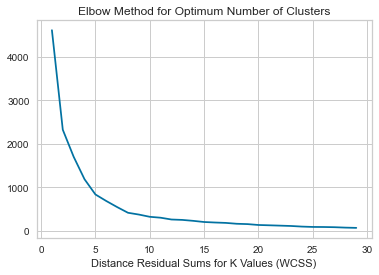

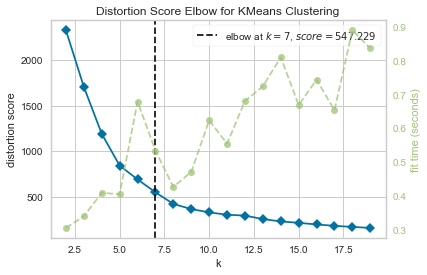

In [36]:
from yellowbrick.cluster import KElbowVisualizer
# KMeans Clustering
kmeans = KMeans()
ssd = []
K = range(1, 30)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(scaled_df_vt)
    ssd.append(kmeans.inertia_)

ssd

plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums for K Values (WCSS)")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k=(2, 20))
visu.fit(scaled_df_vt)
visu.show()

We can find the elbow is K=7

### Prepare Cluster Algorithms

In [37]:
# Use AgglomerativeClustering, KMeans, Birch, SpectralClustering

agglo=AgglomerativeClustering(n_clusters=7)
kmeans=KMeans(n_clusters=7)
birch=Birch(n_clusters=7)
spect=SpectralClustering(n_clusters=7)


#put into a cluster list
clusters = [
    agglo,
    kmeans,
    birch,
    spect]

In [38]:
#list of Clusternames
Clusterer = ["AgglomerativeClustering", "KMeans", "Birch",  "SpectralClustering"]
sh_result = []
ch_result = []
bd_result = []
cl_result = []

In [39]:
# scale and put clusters into pipeline and then fit it
for clust in clusters :
    pip = Pipeline([("scaler", StandardScaler()),("cluster", clust)])
    pip.fit(scaled_df_vt)

    cluster = pip.fit_predict(scaled_df_vt)
    sh_score = silhouette_score(scaled_df_vt, cluster, metric="euclidean") 
    ch_score = calinski_harabasz_score(scaled_df_vt, cluster)
    bd_score = davies_bouldin_score(scaled_df_vt, cluster)
    
   #add to list
    cl_result.append([cluster])
    sh_result.append(sh_score)
    ch_result.append(ch_score)
    bd_result.append(bd_score)

In [40]:
#create dataframe for result
result = pd.DataFrame(zip(Clusterer, sh_result, ch_result, bd_result),
                     columns=["Clusterer", "Silhoutte", "Calinzsky", "Davies"]
                     )
result

,Clusterer,Silhoutte,Calinzsky,Davies
0,AgglomerativeClustering,0.621538,684.228544,0.643602
1,KMeans,0.623741,699.624245,0.641286
2,Birch,0.571407,578.073997,0.796742
3,SpectralClustering,0.591662,378.281286,0.681627


The best algorithms  is Kmeans

#### Create PCA Plot from K-means Algorithms

In [41]:
# preprocessor pipe
preprocessing = Pipeline(
[
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=20))
]
)

#make a dataframe for the PCA components data
PCAdf = pd.DataFrame(
    preprocessing.fit_transform(scaled_df_vt),
    columns=scaled_df_vt.columns,
)


#create only kmean's scaler pipeline
pip_k = Pipeline([("scaler", StandardScaler()),("cluster", kmeans)])
pip_k.fit_predict(scaled_df_vt)

#put kmean predict data to PCA dataframe
PCAdf["predicted_cluster"] = pip_k["cluster"].labels_


PCAdf.head()

,ratingDescription,release_year,ratingLevel_len,rating_Child,rating_Teenager,ratingDescription^2,ratingDescription release_year,ratingDescription ratingLevel_len,ratingDescription rating_Child,ratingDescription rating_Teenager,...,release_year ratingLevel_len,release_year rating_Child,release_year rating_Teenager,ratingLevel_len^2,ratingLevel_len rating_Child,ratingLevel_len rating_Teenager,rating_Child^2,rating_Child rating_Teenager,rating_Teenager^2,predicted_cluster
0,0.426913,1.577159,0.674056,1.719564,-0.021606,-0.015921,0.050155,0.010100,-0.300963,-0.054878,...,0.002455,-0.002570,-0.001291,0.000411,0.002759,1.032123e-14,-1.568893e-15,3.031398e-32,-0.0,2
1,-4.221032,-0.376821,-0.921814,-0.558602,0.002176,-0.040242,-0.013549,-0.025932,-0.010045,-0.009690,...,-0.002340,0.001172,0.000171,-0.000085,0.000350,3.627927e-16,1.093434e-15,-3.065597e-31,0.0,1
2,-3.897598,-0.201099,-1.594151,0.537465,0.586349,0.043574,-0.002079,-0.031763,0.038430,0.019043,...,0.006638,-0.003304,-0.000382,0.000337,-0.001000,3.642743e-16,6.641583e-17,-2.833599e-32,0.0,1
3,2.249806,-3.417463,0.682627,-0.132931,-0.703153,0.293752,0.332306,-0.110561,0.022160,0.025668,...,0.000456,0.001298,-0.000529,0.000110,-0.000337,9.014019e-15,-6.685843e-16,3.522720e-32,0.0,5
4,-4.221032,-0.376821,-0.921814,-0.558602,0.002176,-0.040242,-0.013549,-0.025932,-0.010045,-0.009690,...,-0.002340,0.001172,0.000171,-0.000085,0.000350,3.947471e-15,5.982959e-15,3.406821e-32,0.0,1


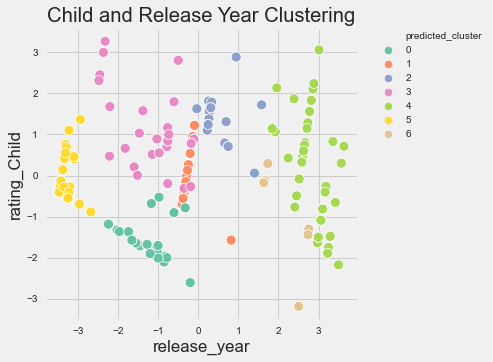

In [42]:
#create the plot for PCA data
plt.style.use("fivethirtyeight")
plt.figure(figsize=(5, 5))

scat = sns.scatterplot(        
    data=PCAdf, 
    x='release_year',
    y='rating_Child',
    hue="predicted_cluster",
    s=100, #size
    palette="Set2",
)
   
scat.set_title(
    "Child and Release Year Clustering"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

The plot shows that 7 clusters display by child and release year. It is good for Netflix to analysize different years movie to the user that at the sme cluster.

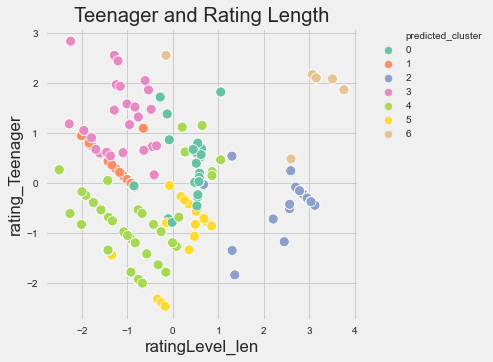

In [43]:
#create the plot for PCA data
plt.style.use("fivethirtyeight")
plt.figure(figsize=(5, 5))

scat = sns.scatterplot(        
    data=PCAdf, 
    x='ratingLevel_len',
    y='rating_Teenager',
    hue="predicted_cluster",
    s=100, #size
    palette="Set2",
)
   
scat.set_title(
    "Teenager and Rating Length"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

The plot shows that 7 clusters display by teenagers and release year 

## Model Planning and Implementation

In [44]:
#Split the scaled dataset
from sklearn.model_selection import train_test_split

#split the dataset
X_train,X_test,Y_train,Y_test=train_test_split(scaled_df_vt, response,test_size=0.25,random_state=42)


### Create Regression and Classification Model

In [45]:
#create Logistic regression to solve binary classification and other classifications list
#Names of the various classification approaches 
names= ["Logististic Regression","AdaBoostRegressor","SVM",  "AdaBoost","MLPClassifier", 
        "RandomForest Classifier","Decision Tree Classifier" ,"Naive Bayes", "XGBoost","Gaussian Process", "SGD Classifier"]

#classification R2 and RMSE score list
r2=[]
rmse=[]
best_parameters=[]

#define classification 
lg=LogisticRegression()
knc=KNeighborsClassifier()
svm=SVC()
adb=AdaBoostClassifier()
mlp = MLPClassifier()
rf=RandomForestClassifier()
dt=DecisionTreeClassifier()
nb=GaussianNB()
xgb=XGBClassifier()
gp=GaussianProcessClassifier()
sgd=SGDClassifier()

#create a classification list for looping
clf=[
    lg,
    knc,
    svm,
    adb,
    mlp,
    rf,
    dt,
    nb,
    xgb,
    gp,
    sgd]

#set the hyperparameter for grid search
lg_p={'solver':[ 'lbfgs', 'liblinear', 'sag', 'saga'],
      'max_iter':[300,500,1000]}
              
knc_p={'n_neighbors': [3,4,5],
       'weights': ['uniform', 'distance'],
       'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
              
svm_p={'kernel':['linear', 'poly', 'rbf'],
        'gamma':['scale', 'auto'],
        'C':[0.025,1]}
              
              
              
adb_p={'n_estimators':[10,20,50,100]}
              
              
mlp_p={'hidden_layer_sizes': [(5,2), (10,5)],
       'activation': ['logistic','tanh', 'relu'],
       'learning_rate': ['constant','adaptive'],
       'max_iter':[1000,2000,3000]}
              
              
rf_p={'n_estimators':[10,20,50,100],
      'criterion':['gini', 'entropy'],
      'max_depth':[6,7,8]}
              
dt_p={'criterion':['gini', 'entropy'],
    'splitter':['best', 'random'],
    'max_depth':[6,7,8]}
            
nb_p={'var_smoothing':[1.0,1e-9]}
              
xgb_p={'n_estimators':[10,20,50,100],
       'max_depth':[6,7,8]}

gp_p={'optimizer':['fmin_l_bfgs_b','callable']}
              
              
sgd_p={'alpha': [0.0001,0.001]}
              

#hyperparameter list for grid search
parameters =[
    lg_p,
    knc_p,
    svm_p,
    adb_p,
    mlp_p,
    rf_p,
    dt_p,
    nb_p,
    xgb_p,
    gp_p,
    sgd_p] 

### Pipeline Implementation with Best Parameter


In [46]:
#create a pipeline for each classification and the best parameter
for c,p in zip(clf,parameters):
   
    clf = GridSearchCV(c,p, n_jobs=-1, cv=5,scoring='accuracy')
    clf.fit(X_train, Y_train)
       
     # Find the optimal parameters
    gs_best = clf.best_estimator_
    pipe = Pipeline([('scaler', StandardScaler()),('classifier', gs_best)])
    pipe.fit(X_train, Y_train)  
    pred = pipe.predict(X_test)
    best_parameters.append(gs_best)
    r2.append(pipe.score(X_test, Y_test))
    rmse.append(mean_squared_error(Y_test, pred)**0.5)



## Results Analysis 

In [47]:
#Create a dataframe for prediction scores
scores_df = pd.DataFrame(zip(names,best_parameters, r2, rmse), columns=['Classifier','Best Parameters', 'Accuracy Score', 'RMSE'])

#save the Results Analysis dataframe to csv
scores_df.to_csv('Result.csv', index=False)

scores_df

,Classifier,Best Parameters,Accuracy Score,RMSE
0,Logististic Regression,"LogisticRegression(max_iter=300, solver='saga')",0.626667,0.611010
1,AdaBoostRegressor,"KNeighborsClassifier(algorithm='ball_tree', we...",0.806667,0.439697
2,SVM,"SVC(C=1, kernel='poly')",0.660000,0.583095
3,AdaBoost,"(DecisionTreeClassifier(max_depth=1, random_st...",0.786667,0.461880
4,MLPClassifier,"MLPClassifier(activation='tanh', hidden_layer_...",0.700000,0.547723
5,RandomForest Classifier,"(DecisionTreeClassifier(criterion='entropy', m...",0.793333,0.454606
6,Decision Tree Classifier,"DecisionTreeClassifier(criterion='entropy', ma...",0.780000,0.469042
7,Naive Bayes,GaussianNB(var_smoothing=1.0),0.660000,0.583095
8,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.806667,0.439697
9,Gaussian Process,GaussianProcessClassifier(),0.686667,0.559762


RandomForest Classifier is the best model. It has highest scores and lowest RMSE. 

### Confusion matrix-Random Forest Model

In [48]:
#get the predition from Random Forest Classifier
rf=RandomForestClassifier(max_depth=8, n_estimators=10)
rf.fit(X_train, Y_train)
pred_rf= rf.predict(X_test)

#create confusion metrix for the Relationship between Predicted price and Actual price
cf_matrix=confusion_matrix(Y_test, pred_rf, labels=[0,1])
cf_matrix

array([[30, 28],
       [ 2, 90]])

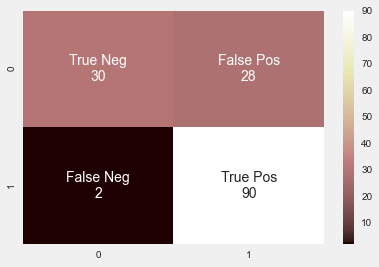

In [49]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_value = [value for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_value )]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='pink')

There are almost 88 cases was positive and predicted positive. It is good for getting higher correct predictions.

### Classification report

In [50]:
# print classification report
print('\n\nDetailed classification report:')
print(classification_report(Y_test, pred_rf, target_names=['Not Recommend', 'Highly Recommend']))



Detailed classification report:
                  precision    recall  f1-score   support

   Not Recommend       0.94      0.52      0.67        58
Highly Recommend       0.76      0.98      0.86        92

        accuracy                           0.80       150
       macro avg       0.85      0.75      0.76       150
    weighted avg       0.83      0.80      0.78       150



There are 77% accuracy of positive predictions for yes of highy recommend and 96% positives that were correctly identified for yes of highly recommend. And the total accuracy of precision is 81%. The total accuracy of recall is 79%.

## Out-of-sample Prediction

#### Import New Sample

In [51]:
#Import the new data for prediction
Xnew = pd.read_csv("X_New_Sample.csv")

#5 samples
Xnew

,ratingDescription,release_year,user_rating_size,ratingLevel_len,rating_Child,rating_Juvenile,rating_Preschool,rating_Teenager
0,70,2015,80,66,1,0,0,0
1,60,2016,81,57,1,0,0,0
2,35,2018,80,3,0,0,1,0
3,90,2020,80,77,0,0,0,1
4,60,2014,82,26,1,0,0,0


#### Scaling and Transform the new sample 

In [52]:
#selected features into a new dataframe
Xnew=Xnew[['ratingDescription','release_year','ratingLevel_len','rating_Child','rating_Teenager']]

In [53]:
#Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2, include_bias=False)
res = pf.fit_transform(Xnew)

In [54]:
p_df = pd.DataFrame(res,
                  columns=pf.get_feature_names(Xnew.columns)
                  )
p_df.head()

,ratingDescription,release_year,ratingLevel_len,rating_Child,rating_Teenager,ratingDescription^2,ratingDescription release_year,ratingDescription ratingLevel_len,ratingDescription rating_Child,ratingDescription rating_Teenager,release_year^2,release_year ratingLevel_len,release_year rating_Child,release_year rating_Teenager,ratingLevel_len^2,ratingLevel_len rating_Child,ratingLevel_len rating_Teenager,rating_Child^2,rating_Child rating_Teenager,rating_Teenager^2
0,70.0,2015.0,66.0,1.0,0.0,4900.0,141050.0,4620.0,70.0,0.0,4060225.0,132990.0,2015.0,0.0,4356.0,66.0,0.0,1.0,0.0,0.0
1,60.0,2016.0,57.0,1.0,0.0,3600.0,120960.0,3420.0,60.0,0.0,4064256.0,114912.0,2016.0,0.0,3249.0,57.0,0.0,1.0,0.0,0.0
2,35.0,2018.0,3.0,0.0,0.0,1225.0,70630.0,105.0,0.0,0.0,4072324.0,6054.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0
3,90.0,2020.0,77.0,0.0,1.0,8100.0,181800.0,6930.0,0.0,90.0,4080400.0,155540.0,0.0,2020.0,5929.0,0.0,77.0,0.0,0.0,1.0
4,60.0,2014.0,26.0,1.0,0.0,3600.0,120840.0,1560.0,60.0,0.0,4056196.0,52364.0,2014.0,0.0,676.0,26.0,0.0,1.0,0.0,0.0


In [55]:
#Robust Scaling
rs = RobustScaler()
scaled_features = rs.fit_transform(p_df)

# remake the feature dataframe
scaled_Xnew = pd.DataFrame(scaled_features, columns=p_df.columns)
scaled_Xnew

,ratingDescription,release_year,ratingLevel_len,rating_Child,rating_Teenager,ratingDescription^2,ratingDescription release_year,ratingDescription ratingLevel_len,ratingDescription rating_Child,ratingDescription rating_Teenager,release_year^2,release_year ratingLevel_len,release_year rating_Child,release_year rating_Teenager,ratingLevel_len^2,ratingLevel_len rating_Child,ratingLevel_len rating_Teenager,rating_Child^2,rating_Child rating_Teenager,rating_Teenager^2
0,1.0,-0.333333,0.225,0.0,0.0,1.000000,0.994062,0.392157,0.166667,0.0,-0.333168,0.224220,0.000496,0.0,0.300815,0.701754,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000993,0.0,0.000000,0.543860,0.0,0.0,0.0,0.0
2,-2.5,0.666667,-1.350,-1.0,0.0,-1.826923,-2.490351,-1.083333,-1.000000,0.0,0.666832,-1.350160,-0.999504,0.0,-0.880435,-0.456140,0.0,-1.0,0.0,0.0
3,3.0,1.333333,0.500,-1.0,1.0,3.461538,3.010391,1.147059,-1.000000,90.0,1.334325,0.503907,-0.999504,2020.0,0.728261,-0.456140,77.0,-1.0,0.0,1.0
4,0.0,-0.666667,-0.775,0.0,0.0,0.000000,-0.005938,-0.607843,0.000000,0.0,-0.666171,-0.775780,0.000000,0.0,-0.699185,0.000000,0.0,0.0,0.0,0.0


In [56]:
# make a prediction for new sample
#Random Forest is the Best model
ynew = rf.predict(scaled_Xnew)
ynew

array([0, 1, 1, 1, 1], dtype=uint8)

In [57]:
#result
i=0
for r in ynew:
    if r ==0:
        
        print("Sampe ",i,"Predicted result is Not Recommend")
        i += 1
    else:
        print("Sampe ",i,"Predicted result is Highly-Recommend")
        i += 1


Sampe  0 Predicted result is Not Recommend
Sampe  1 Predicted result is Highly-Recommend
Sampe  2 Predicted result is Highly-Recommend
Sampe  3 Predicted result is Highly-Recommend
Sampe  4 Predicted result is Highly-Recommend


The result above shows that there are 3 out of 5 samples has highly recommend.